# Project 1 Part 1 - Dimension reduction and predictive modeling

### Basic setups and preparations

*Import libraries*

In [57]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [46]:
from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

*Read data*

In [23]:
cancerData = pd.read_csv('TCGAdata.txt', sep=' ')
cancerData.shape
# cancerData.head()

(2887, 2000)

In [37]:
cancerLabel = pd.read_csv('TCGAlabels', sep=' ')
cancerLabel.shape

(2887, 1)

In [38]:
cancerData['cancer'] = cancerLabel

*Shuffle the data*

In [39]:
data_shuffled = cancerData.sample(frac=1.0, random_state=0)
X = data_shuffled.drop('cancer', axis=1)
y = data_shuffled['cancer']

*Generate one data split for test*

In [40]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(
    X, y,
    # todo whether to turn on the 'stratify'
    stratify= y,
    test_size=0.25,
    random_state=0)

*Basics for PCA*

In [41]:
pca = PCA(n_components=50, whiten=True, random_state=0).fit(X_train0)
X_train_pca0 = pca.transform(X_train0)
X_test_pca0 = pca.transform(X_test0)

print("X_train_pca.shape: {}".format(X_train_pca0.shape))

X_train_pca.shape: (2165, 50)


In [42]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_pca0, y_train0)
print(f"Test set accuracy: {knn.score(X_test_pca0, y_test0)}")

Test set accuracy: 0.9847645429362881


*Based on the variance explained, we better limit the pc number to 30 for optimum principle compenents search*

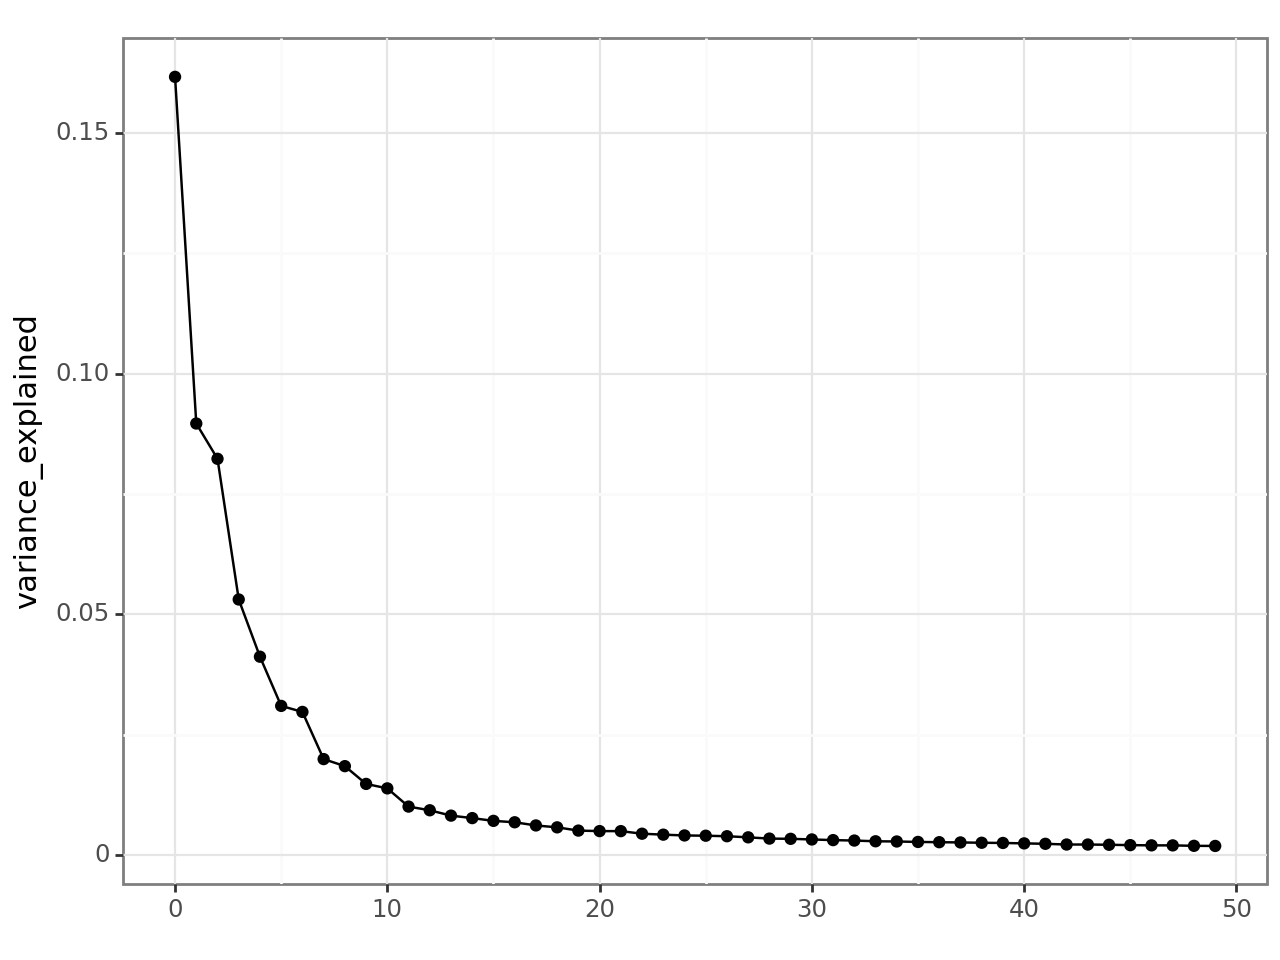

<Figure Size: (640 x 480)>

In [43]:
pca.explained_variance_ratio_
variance_explained = pd.DataFrame(pca.explained_variance_ratio_)
variance_explained.columns = ['variance_explained']

p = (ggplot(variance_explained, aes(x=variance_explained.index, y='variance_explained'))
     + geom_line()
     + geom_point()
     + theme_minimal()
     + theme_bw()
     )
p

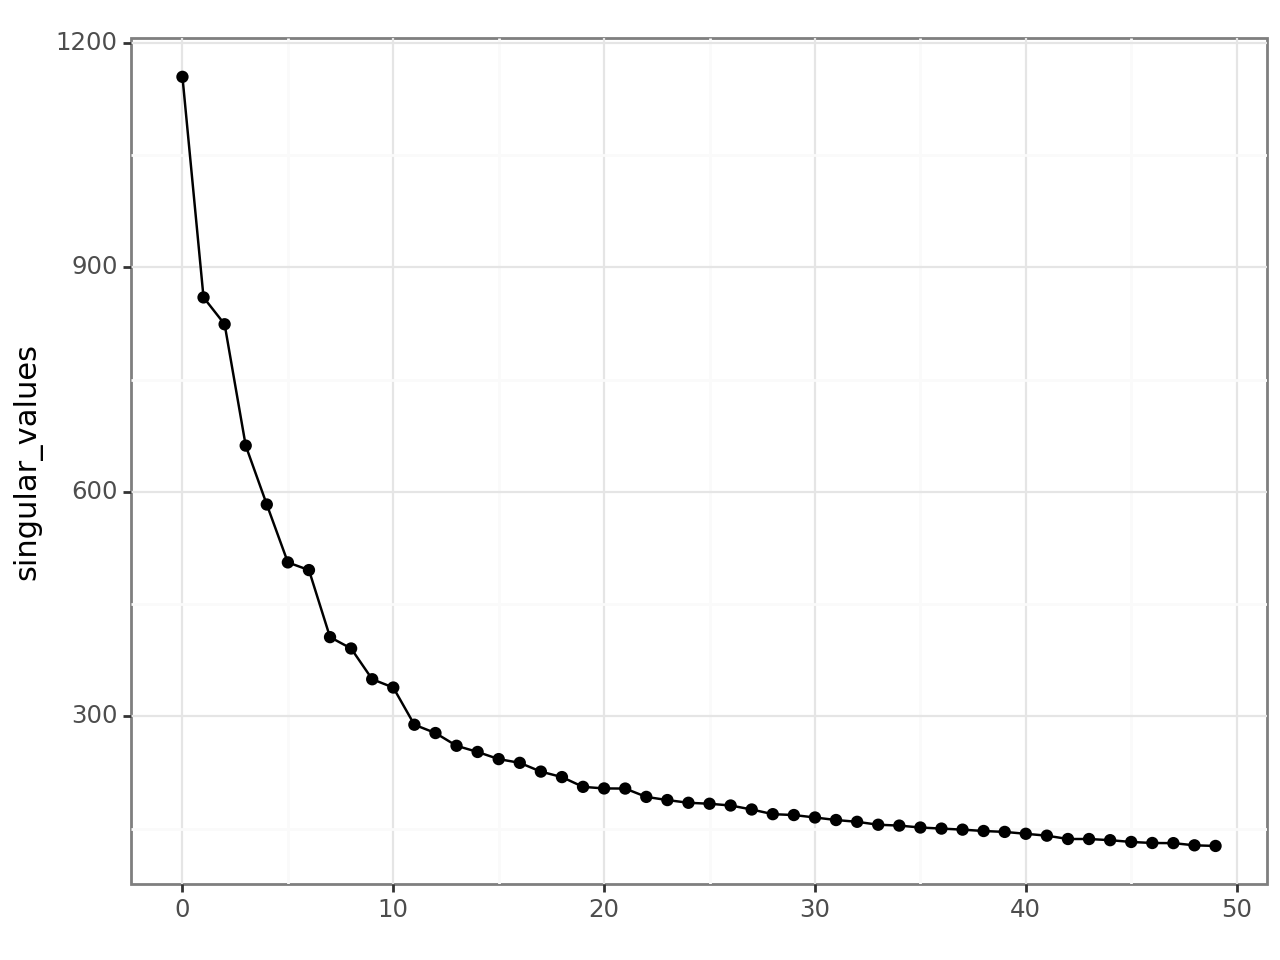

<Figure Size: (640 x 480)>

In [44]:
pca.singular_values_
eigenvalues = pd.DataFrame(pca.singular_values_)
eigenvalues.columns = ['singular_values']

p = (ggplot(eigenvalues, aes(x=variance_explained.index, y='singular_values'))
     + geom_line()
     + geom_point()
     + theme_minimal()
     + theme_bw()
     )
p

#### Class for selecting the optimal PCs based on Cross-validation result and performance evaluating

In [48]:
class ModelEvaluator:
    def __init__(self, X_train, X_test, y_train, y_test, external_param=None):
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        self.clf, self.clf_name = self.clf_category(external_param)
        self.pca = PCA(n_components=50).fit(self.X_train)
        self.X_train_pca = self.pca.transform(self.X_train)
        self.X_test_pca = self.pca.transform(self.X_test)

    def clf_category(self, clf_name = None):
        if clf_name is not None:
            # return KNeighborsClassifier(), 'n_neighbors'
            if clf_name == 'knn':
                knn = KNeighborsClassifier()
                return knn, 'knn'
            if clf_name == 'dtree':
                dtree = DecisionTreeClassifier()
                return dtree, 'dtree'
            if clf_name == 'SVC':
                svc = SVC()
                return svc, 'SVC'
            if clf_name == 'RF':
                rf = RandomForestClassifier(n_jobs=-1, n_estimators = 10)
                return rf, 'RF'
        else :
            return KNeighborsClassifier(), 'knn'

    def find_optimal_pc_with_cv(self,k):
        if self.clf_name == 'knn':
            self.clf.n_neighbors = k
        elif self.clf_name == 'dtree':
            self.clf.max_depth = k
        elif self.clf_name == 'SVC':
            self.clf.C = k
        elif self.clf_name == 'RF':
            self.clf.max_depth = k
        else:
            raise ValueError("Invalid type")

        optimal_pc = None
        max_score = float('-inf')
        pc_num = 50
        # 0~50 PC choice
        avg_score = np.zeros(pc_num)

        # Use cv to find best pca number.
        for n_pc in range(1, pc_num):
            self.clf.fit(self.X_train_pca[:,:n_pc], self.y_train)
            avg_score[n_pc] = cross_val_score(self.clf, self.X_train_pca[:,:n_pc], self.y_train).mean()

        max_score = np.max(avg_score)
        optimal_pc = np.argmax(avg_score)

        self.clf.fit(self.X_train_pca[:,:optimal_pc], self.y_train)
        # max_score = cross_val_score(self.clf, self.X_train_pca[:, :optimal_pc], self.y_train)
        max_train_score = self.clf.score(self.X_train_pca[:, :optimal_pc], self.y_train)
        max_test_score = self.clf.score(self.X_test_pca[:, :optimal_pc], self.y_test)

        return optimal_pc, max_score, max_train_score, max_test_score

#### Class for selecting the optimal features based on Cross-validation result and performance evaluating

In [49]:
class Model_Fs_Selection:
    def __init__(self, X_train, X_test, y_train, y_test, fs_select=100, external_param=None):
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        self.fs_select = fs_select
        self.clf, self.clf_name = self.clf_category(external_param)
        self.fs = SelectKBest(f_classif, k=fs_select)
        self.Xtrain_fs = self.fs.fit_transform(self.X_train, self.y_train)
        self.X_test_fs =  self.fs.transform(self.X_test)

    def clf_category(self, clf_name = None):    
        if clf_name is not None:
            # return KNeighborsClassifier(), 'n_neighbors'
            if clf_name == 'knn':
                knn = KNeighborsClassifier()
                return knn, 'knn'
            if clf_name == 'dtree':
                dtree = DecisionTreeClassifier()
                return dtree, 'dtree'
            if clf_name == 'SVC':
                svc = SVC()
                return svc, 'SVC'
            if clf_name == 'RF':
                rf = RandomForestClassifier(n_jobs=-1, n_estimators = 10)
                return rf, 'RF'
        else :
            return KNeighborsClassifier(), 'knn'
    
    def find_optimal_fs_with_cv(self,k):
        if self.clf_name == 'knn':
            self.clf.n_neighbors = k
        elif self.clf_name == 'dtree':
            self.clf.max_depth = k
        elif self.clf_name == 'RF':
            self.clf.max_depth = k
        elif self.clf_name == 'SVC':
            self.clf.C = k
        else:
            raise ValueError("Invalid classifer type")
        
        # optimal_pc = None
        max_score = float('-inf')
        fs_num = self.fs_select
        # 0~50 PC choice
        avg_score = np.zeros(fs_num)

        # Use cv to find best fs number.
        for n_fs in range(1, fs_num):
            self.clf.fit(self.Xtrain_fs[:,:n_fs], self.y_train)
            avg_score[n_fs] = cross_val_score(self.clf, self.Xtrain_fs[:,:n_fs], self.y_train).mean()
            
        max_score = np.max(avg_score)
        optimal_fs = np.argmax(avg_score)
        
        self.clf.fit(self.Xtrain_fs[:,:optimal_fs], self.y_train)
        max_train_score = self.clf.score(self.Xtrain_fs[:, :optimal_fs], self.y_train)
        max_test_score = self.clf.score(self.X_test_fs[:, :optimal_fs], self.y_test)
        
        return optimal_fs, max_score, max_train_score, max_test_score

### 1.1 Perform cross validation to select the number of principle components that optimizing predictive performance & 1.2 Perform cross validation to select the number of features(genes) that optimizing predictive performance

#### KNN

In [16]:
# results_df1 = pd.DataFrame(columns=['trainning size', 'k', 'optimal_pc', 'cv_accuracy', 'train_accuracy', 'test_accuracy'])
results_dfknn = pd.DataFrame(columns=['trainning size', 'k', 'optimal_pc', 'cv_error', 'training_error', 'test_error'])

for q in [1,2,3]:
    size = q * 0.25

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        # todo whether to turn on the 'stratify'
        stratify= y,
        train_size=size,
        random_state=0)

    evaluator = ModelEvaluator(X_train, X_test, y_train, y_test, 'knn')

    for k in range(1, 50):
        optimal_pc, cv_accuracy, train_accuracy, test_accuracy = evaluator.find_optimal_pc_with_cv(k)
        cv_error, training_error, test_error = 1 - cv_accuracy, 1 - train_accuracy, 1 - test_accuracy
        results_dfknn.loc[len(results_dfknn)] = size, k, optimal_pc, cv_error, training_error, test_error
        # results_df1.loc[len(results_df1)] = size, k, optimal_pc, cv_accuracy, train_accuracy, test_accuracy

print(results_dfknn.head())

   trainning size    k  optimal_pc  cv_error  training_error  test_error
0            0.25  1.0         7.0  0.018017        0.000000    0.014774
1            0.25  2.0         6.0  0.022184        0.016644    0.015697
2            0.25  3.0        42.0  0.018017        0.012483    0.009234
3            0.25  4.0        44.0  0.015239        0.012483    0.009695
4            0.25  5.0        26.0  0.013860        0.015257    0.005078


d:\anaconda3\lib\site-packages\mizani\scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
d:\anaconda3\lib\site-packages\mizani\scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


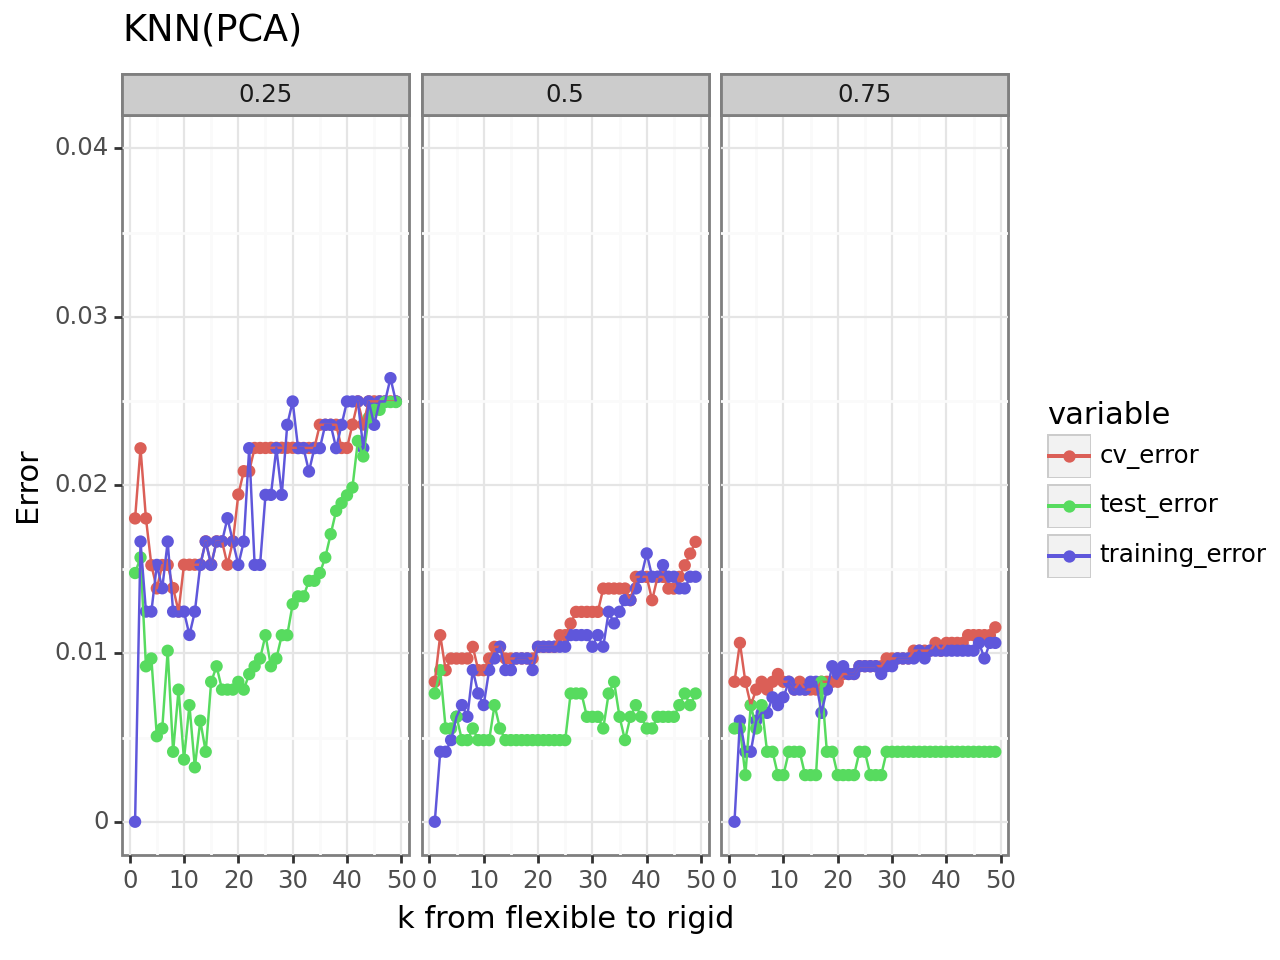

<Figure Size: (640 x 480)>

In [110]:
df_results_dfknn = pd.melt(results_dfknn, id_vars=["k", 'trainning size'], value_vars=["cv_error", 'training_error', 'test_error'])
p1 = (ggplot(df_results_dfknn, aes(x = 'k', y = 'value', color = 'variable'))
      + geom_point()
      + geom_line()
      + facet_wrap('trainning size', nrow = 1)
      + ylim(0, 0.04)
      + labs(x = 'k from flexible to rigid', y = 'Error', title = 'KNN(PCA)')
      + theme_minimal()
      + theme_bw()
      )
p1

In [60]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [61]:
# results_df1 = pd.DataFrame(columns=['trainning size', 'k', 'optimal_pc', 'cv_accuracy', 'train_accuracy', 'test_accuracy'])
results_dfknn_FS = pd.DataFrame(columns=['trainning size', 'k', 'optimal_features', 'cv_error', 'training_error', 'test_error'])

for q in [1,2,3]:
    size = q * 0.25

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        stratify= y,
        train_size=size,
        random_state=0)
    
    evaluator = Model_Fs_Selection(X_train, X_test, y_train, y_test, 100,'knn')
    
    for k in range(1, 50):
        optimal_pc, cv_accuracy, train_accuracy, test_accuracy = evaluator.find_optimal_fs_with_cv(k)
        cv_error, training_error, test_error = 1 - cv_accuracy, 1 - train_accuracy, 1 - test_accuracy
        results_dfknn_FS.loc[len(results_dfknn_FS)] = size, k, optimal_pc, cv_error, training_error, test_error
        # results_df1.loc[len(results_df1)] = size, k, optimal_pc, cv_accuracy, train_accuracy, test_accuracy

print(results_dfknn_FS.head())

   trainning size    k  optimal_features  cv_error  training_error  test_error
0            0.25  1.0              98.0  0.013879        0.000000    0.009695
1            0.25  2.0              99.0  0.018027        0.013870    0.012927
2            0.25  3.0              40.0  0.016648        0.011096    0.015235
3            0.25  4.0              39.0  0.019425        0.015257    0.016159
4            0.25  5.0              40.0  0.013879        0.011096    0.017544


In [ ]:
# results_df1 = pd.DataFrame(columns=['trainning size', 'k', 'optimal_pc', 'cv_accuracy', 'train_accuracy', 'test_accuracy'])
results_dfknn_FS = pd.DataFrame(columns=['trainning size', 'k', 'optimal_features', 'cv_error', 'training_error', 'test_error'])

for q in [1,2,3]:
    size = q * 0.25

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        stratify= y,
        train_size=size,
        random_state=0)
    
    evaluator = Model_Fs_Selection(X_train, X_test, y_train, y_test, 100,'knn')
    
    for k in range(1, 50):
        optimal_pc, cv_accuracy, train_accuracy, test_accuracy = evaluator.find_optimal_fs_with_cv(k)
        cv_error, training_error, test_error = 1 - cv_accuracy, 1 - train_accuracy, 1 - test_accuracy
        results_dfknn_FS.loc[len(results_dfknn_FS)] = size, k, optimal_pc, cv_error, training_error, test_error
        # results_df1.loc[len(results_df1)] = size, k, optimal_pc, cv_accuracy, train_accuracy, test_accuracy

print(results_dfknn_FS.head())

d:\anaconda3\lib\site-packages\mizani\scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
d:\anaconda3\lib\site-packages\mizani\scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


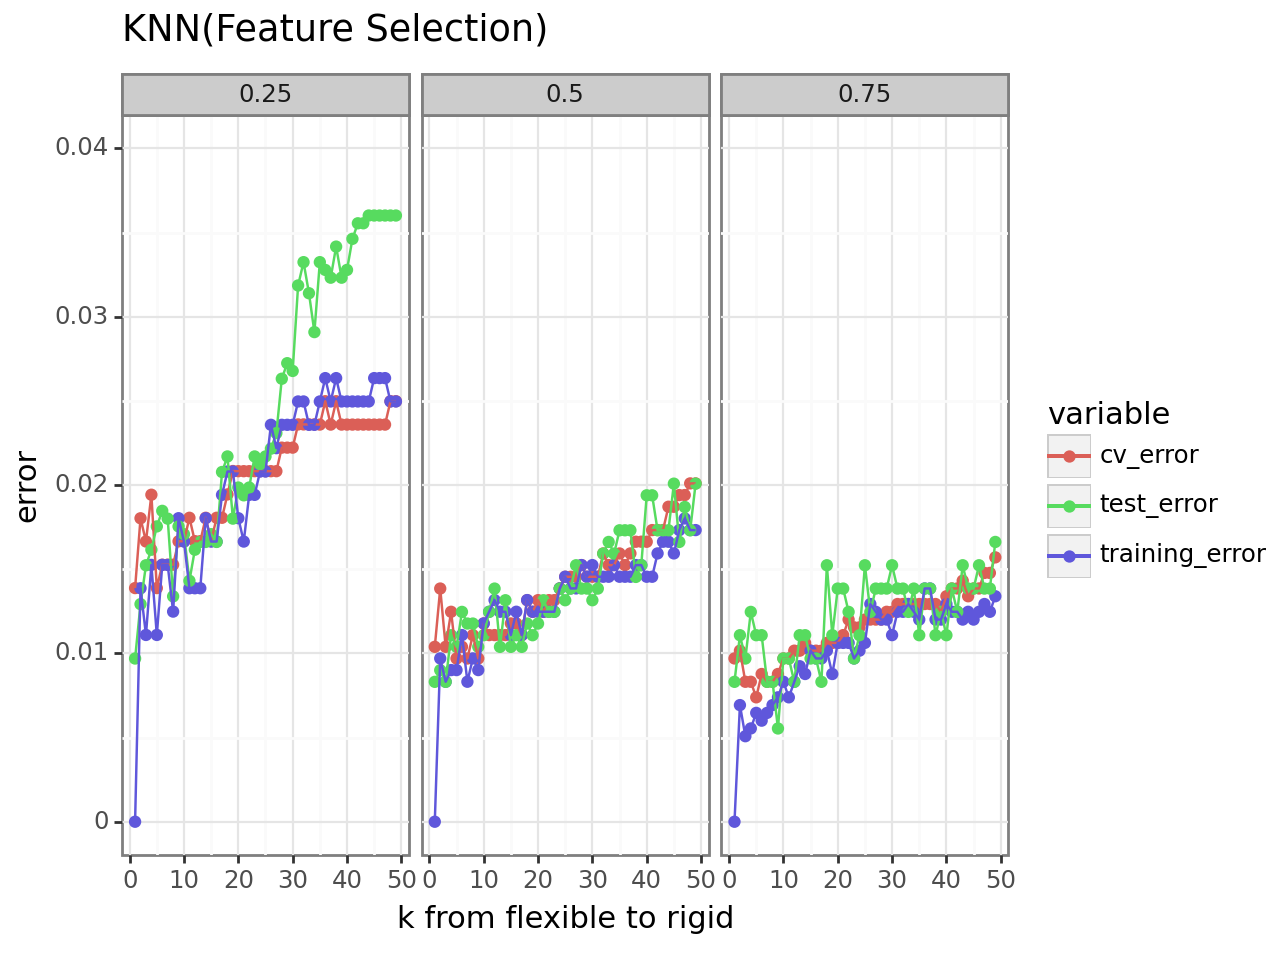

<Figure Size: (640 x 480)>

In [109]:
df_results_dfknn_FS = pd.melt(results_dfknn_FS, id_vars=["k", 'trainning size'], value_vars=["cv_error", 'training_error', 'test_error'])
p3 = (ggplot(df_results_dfknn_FS, aes(x = 'k', y = 'value', color = 'variable'))
      + geom_point()
      + geom_line()
      + facet_wrap('trainning size', nrow = 1)
      + labs(x = 'k from flexible to rigid', y = 'error', title = 'KNN(Feature Selection)')
      + theme_minimal()
      + theme_bw()
      + ylim(0, 0.04)
      )
p3

*Alternative way to present result：Accuracy*

   trainning size    k  optimal_pc  cv_error  training_error  test_error  \
0            0.25  1.0         7.0  0.018017        0.000000    0.014774   
1            0.25  2.0         6.0  0.022184        0.016644    0.015697   
2            0.25  3.0        42.0  0.018017        0.012483    0.009234   
3            0.25  4.0        44.0  0.015239        0.012483    0.009695   
4            0.25  5.0        26.0  0.013860        0.015257    0.005078   

   cv_accuracy  training_accuracy  test_accuracy  
0     0.981983           1.000000       0.985226  
1     0.977816           0.983356       0.984303  
2     0.981983           0.987517       0.990766  
3     0.984761           0.987517       0.990305  
4     0.986140           0.984743       0.994922  


d:\anaconda3\lib\site-packages\mizani\scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
d:\anaconda3\lib\site-packages\mizani\scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


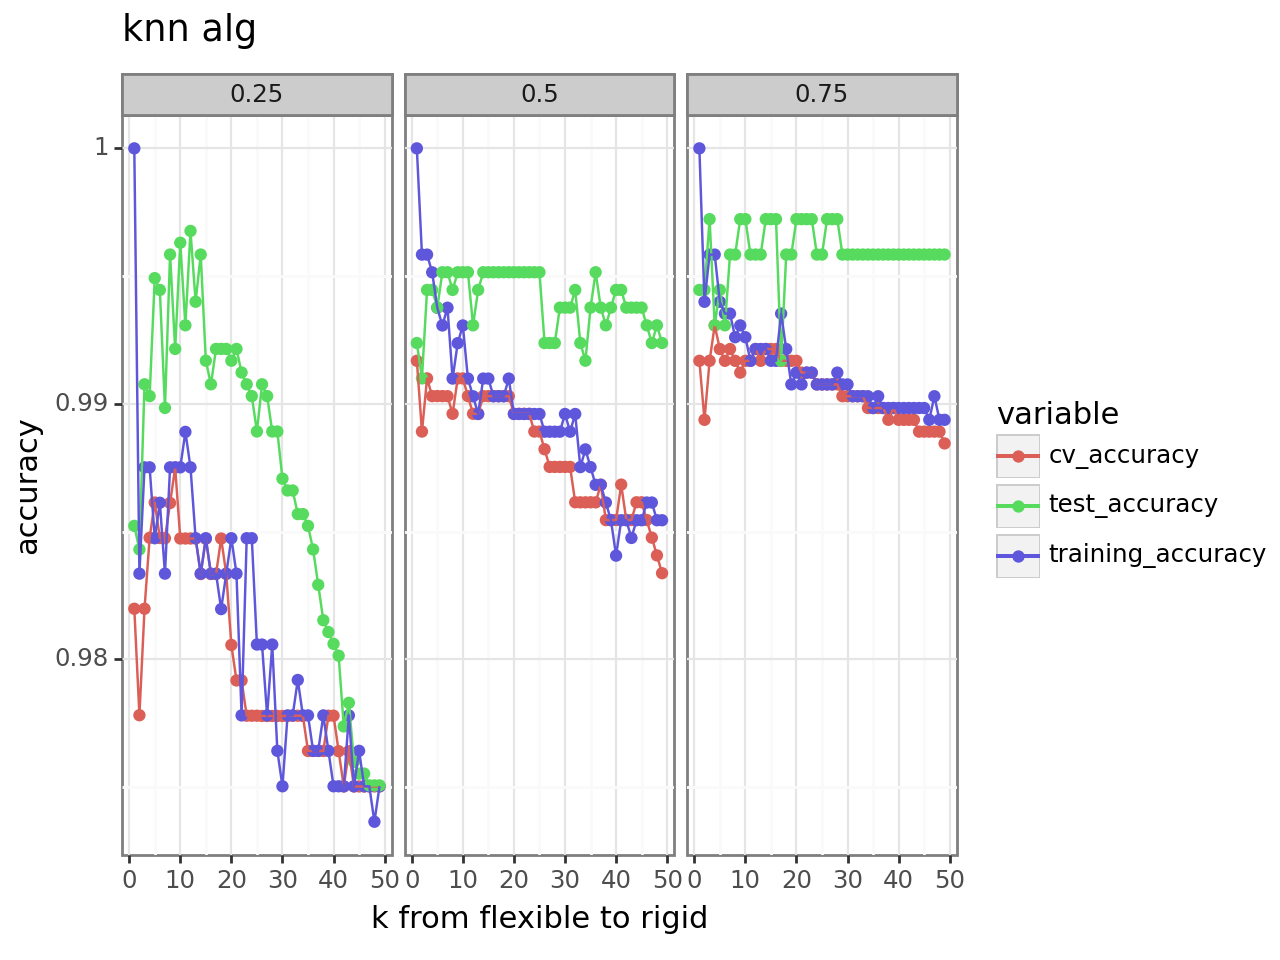

<Figure Size: (640 x 480)>

In [18]:
results_dfknn['cv_accuracy'] = 1 - results_dfknn['cv_error']
results_dfknn['training_accuracy'] = 1 - results_dfknn['training_error']
results_dfknn['test_accuracy'] = 1 - results_dfknn['test_error']

print(results_dfknn.head())

df_results_dfknn = pd.melt(results_dfknn, id_vars=["k", 'trainning size'], value_vars=["cv_accuracy", 'training_accuracy', 'test_accuracy'])
p1 = (ggplot(df_results_dfknn, aes(x = 'k', y = 'value', color = 'variable'))
      + geom_point()
      + geom_line()
      + facet_wrap('trainning size', nrow = 1)
      + labs(x = 'k from flexible to rigid', y = 'accuracy', title = 'knn alg')
      + theme_minimal()
      + theme_bw()
      )
p1

*SVC*

In [99]:
results_dfsvc = pd.DataFrame(columns=['trainning size', 'k', 'optimal_pc', 'cv_error', 'training_error', 'test_error'])

for q in [1,2,3]:
    size = q * 0.25

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        # todo whether to turn on the 'stratify'
        stratify= y,
        train_size=size,
        random_state=0)

    evaluator = ModelEvaluator(X_train, X_test, y_train, y_test, 'SVC')

    for k in range(1, 20):
        optimal_pc, cv_accuracy, train_accuracy, test_accuracy = evaluator.find_optimal_pc_with_cv(k)
        cv_error, training_error, test_error = 1 - cv_accuracy, 1 - train_accuracy, 1 - test_accuracy
        results_dfsvc.loc[len(results_dfsvc)] = size, k, optimal_pc, cv_error, training_error, test_error
        # results_df1.loc[len(results_df1)] = size, k, optimal_pc, cv_accuracy, train_accuracy, test_accuracy

print(results_dfsvc.head())

   trainning size    k  optimal_pc  cv_error  training_error  test_error
0            0.25  1.0         7.0  0.016628        0.009709    0.006925
1            0.25  2.0        21.0  0.018027        0.002774    0.004617
2            0.25  3.0        45.0  0.016628        0.000000    0.005078
3            0.25  4.0        42.0  0.016628        0.000000    0.005078
4            0.25  5.0        42.0  0.016628        0.000000    0.005078


d:\anaconda3\lib\site-packages\mizani\scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
d:\anaconda3\lib\site-packages\mizani\scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


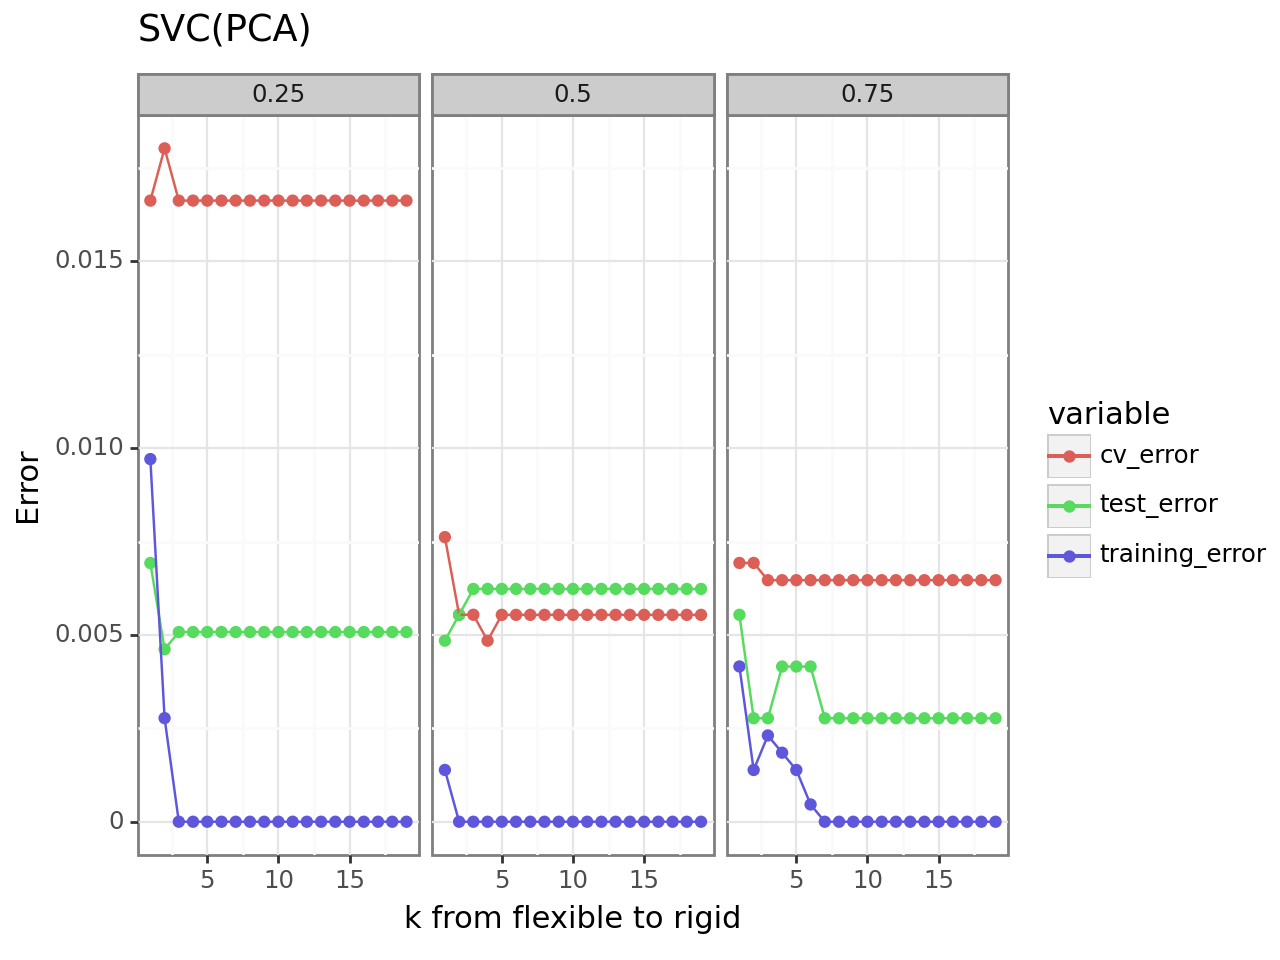

<Figure Size: (640 x 480)>

In [112]:
df_results_dfsvc = pd.melt(results_dfsvc, id_vars=["k", 'trainning size'], value_vars=["cv_error", 'training_error', 'test_error'])
p1 = (ggplot(df_results_dfsvc, aes(x = 'k', y = 'value', color = 'variable'))
      + geom_point()
      + geom_line()
      + facet_wrap('trainning size', nrow = 1)
      + labs(x = 'k from flexible to rigid', y = 'Error', title = 'SVC(PCA)')
      + theme_minimal()
      + theme_bw()
      )
p1

In [114]:
results_dfsvc_FS = pd.DataFrame(columns=['trainning size', 'k', 'optimal_features', 'cv_error', 'training_error', 'test_error'])

for q in [1,2,3]:
    size = q * 0.25

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        # todo whether to turn on the 'stratify'
        stratify= y,
        train_size=size,
        random_state=0)

    evaluator = ModelEvaluator(X_train, X_test, y_train, y_test, 'SVC')
    for k in range(1, 20):
        optimal_pc, cv_accuracy, train_accuracy, test_accuracy = evaluator.find_optimal_pc_with_cv(k)
        cv_error, training_error, test_error = 1 - cv_accuracy, 1 - train_accuracy, 1 - test_accuracy
        results_dfsvc_FS.loc[len(results_dfsvc_FS)] = size, k, optimal_pc, cv_error, training_error, test_error
        # results_df1.loc[len(results_df1)] = size, k, optimal_pc, cv_accuracy, train_accuracy, test_accuracy

print(results_dfsvc_FS.head())

   trainning size    k  optimal_features  cv_error  training_error  test_error
0            0.25  1.0               7.0  0.016628        0.009709    0.006925
1            0.25  2.0              21.0  0.018027        0.002774    0.004617
2            0.25  3.0              41.0  0.016638        0.000000    0.005078
3            0.25  4.0              41.0  0.016628        0.000000    0.005078
4            0.25  5.0              41.0  0.016628        0.000000    0.005540


d:\anaconda3\lib\site-packages\mizani\scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
d:\anaconda3\lib\site-packages\mizani\scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


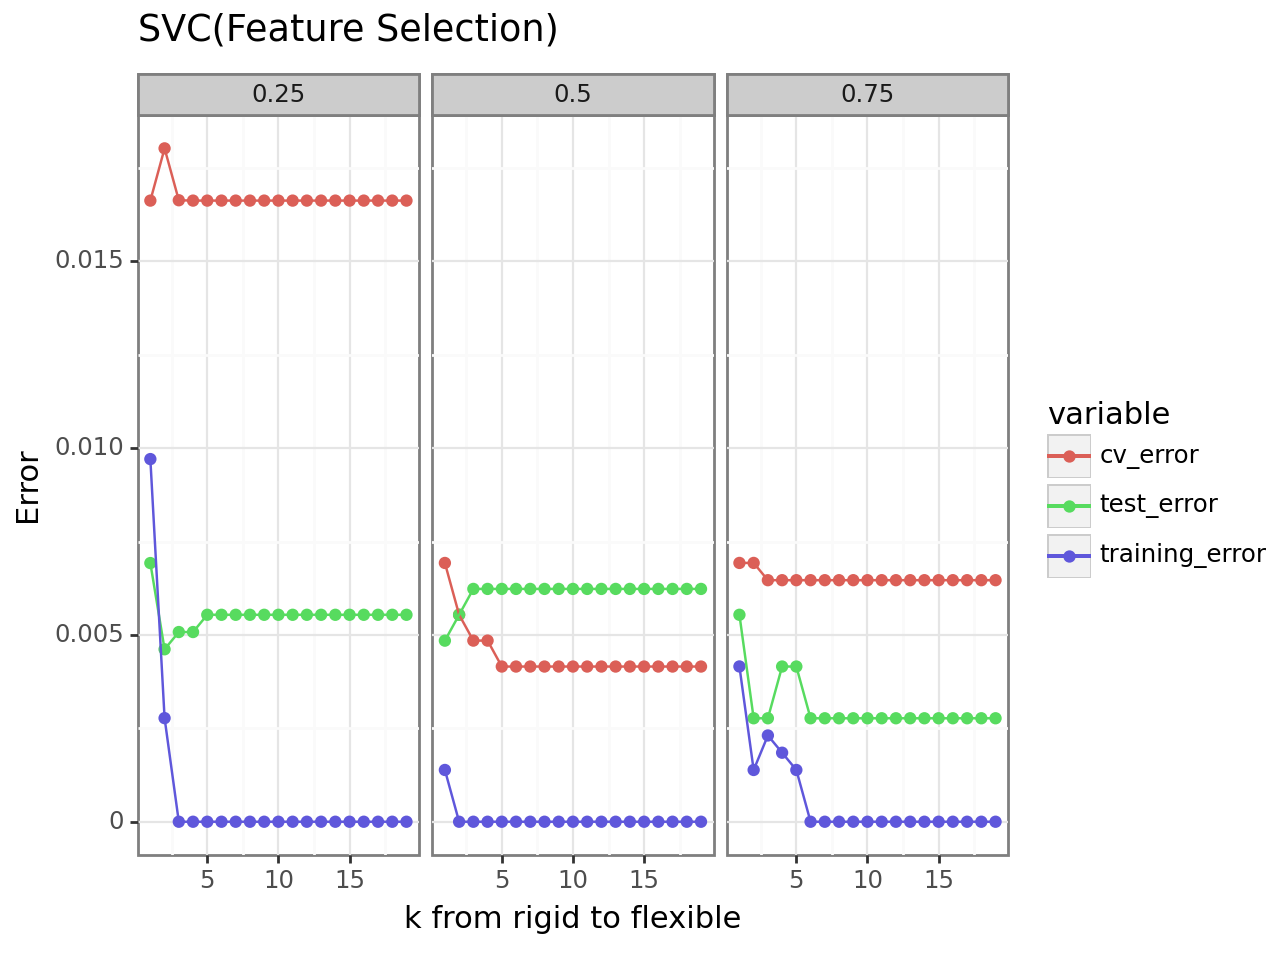

<Figure Size: (640 x 480)>

In [115]:
df_results_dfsvc_FS = pd.melt(results_dfsvc_FS, id_vars=["k", 'trainning size'], value_vars=["cv_error", 'training_error', 'test_error'])
p4 = (ggplot(df_results_dfsvc_FS, aes(x = 'k', y = 'value', color = 'variable'))
      + geom_point()
      + geom_line()
      + facet_wrap('trainning size', nrow = 1)
      + labs(x = 'k from rigid to flexible', y = 'Error', title = 'SVC(Feature Selection)')
      + theme_minimal()
      + theme_bw()
      )
p4

#### Decision tree

In [116]:
results_dfdtree = pd.DataFrame(columns=['trainning size', 'k', 'optimal_pc', 'cv_error', 'training_error', 'test_error'])

for q in [1,2,3]:
    size = q * 0.25

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        # todo whether to turn on the 'stratify'
        stratify= y,
        train_size=size,
        random_state=0)

    evaluator = ModelEvaluator(X_train, X_test, y_train, y_test, 'dtree')
    for k in range(1, 30):
        optimal_pc, cv_accuracy, train_accuracy, test_accuracy = evaluator.find_optimal_pc_with_cv(k)
        cv_error, training_error, test_error = 1 - cv_accuracy, 1 - train_accuracy, 1 - test_accuracy
        results_dfdtree.loc[len(results_dfdtree)] = size, k, optimal_pc, cv_error, training_error, test_error
        # results_df1.loc[len(results_df1)] = size, k, optimal_pc, cv_accuracy, train_accuracy, test_accuracy

print(results_dfdtree.head())

   trainning size    k  optimal_pc  cv_error  training_error  test_error
0            0.25  1.0         1.0  0.423056        0.410541    0.419668
1            0.25  2.0         2.0  0.238602        0.224688    0.247922
2            0.25  3.0         4.0  0.153985        0.135922    0.154201
3            0.25  4.0        17.0  0.099875        0.080444    0.105263
4            0.25  5.0         7.0  0.054080        0.034674    0.052632


d:\anaconda3\lib\site-packages\mizani\scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
d:\anaconda3\lib\site-packages\mizani\scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


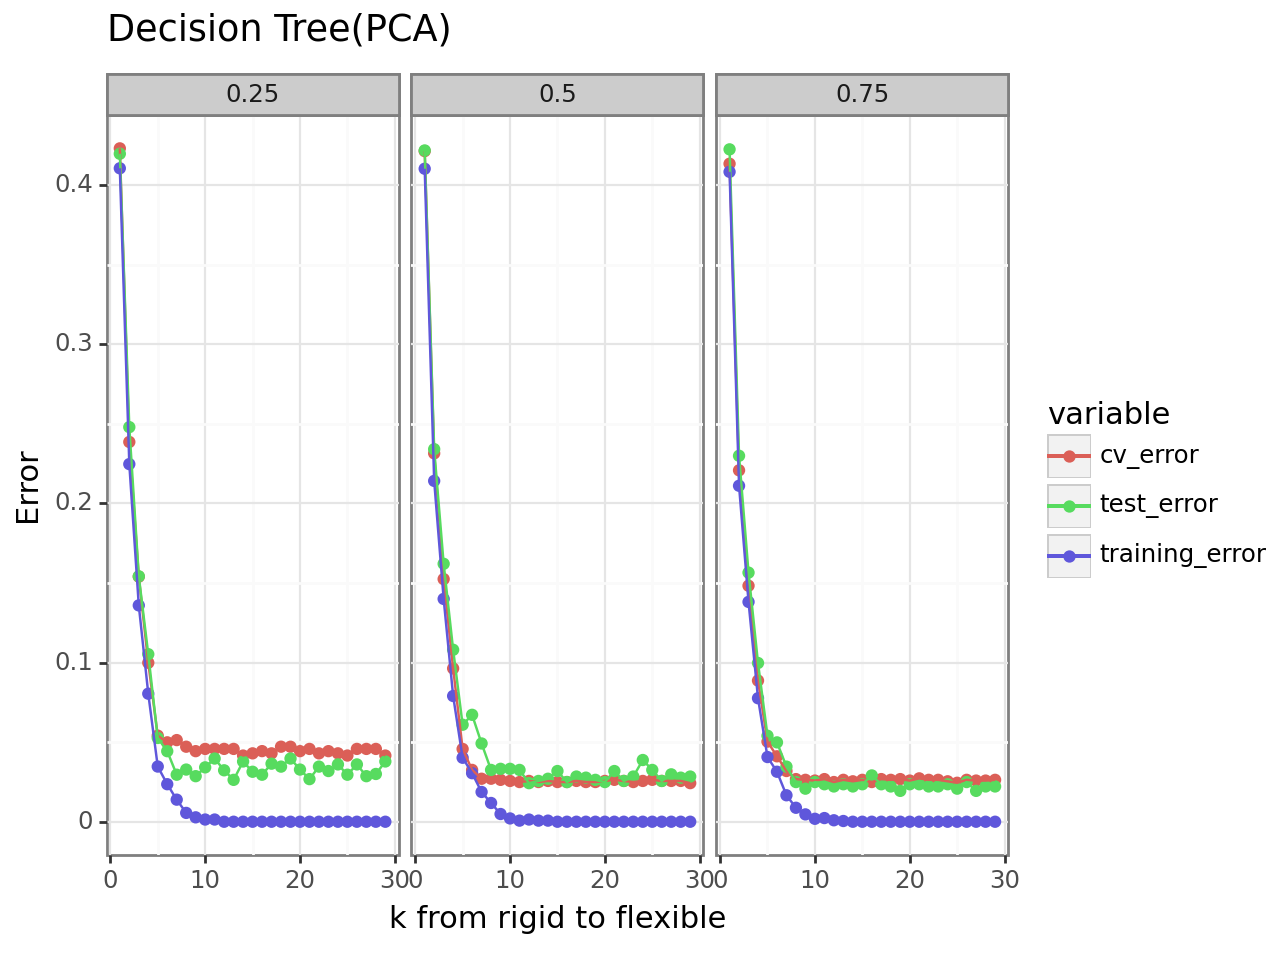

<Figure Size: (640 x 480)>

In [117]:
df_results_dfdtree = pd.melt(results_dfdtree, id_vars=["k", 'trainning size'], value_vars=["cv_error", 'training_error', 'test_error'])
p2 = (ggplot(df_results_dfdtree, aes(x = 'k', y = 'value', color = 'variable'))
      + geom_point()
      + geom_line()
      + facet_wrap('trainning size', nrow = 1)
      + labs(x = 'k from rigid to flexible', y = 'Error', title = 'Decision Tree(PCA)')
      + theme_minimal()
      + theme_bw()
      )
p2

In [118]:
results_dfdtree_FS = pd.DataFrame(columns=['trainning size', 'k', 'optimal_features', 'cv_error', 'training_error', 'test_error'])

for q in [1,2,3]:
    size = q * 0.25

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        # todo whether to turn on the 'stratify'
        stratify= y,
        train_size=size,
        random_state=0)

    evaluator = ModelEvaluator(X_train, X_test, y_train, y_test, 'dtree')
    for k in range(1, 30):
        optimal_pc, cv_accuracy, train_accuracy, test_accuracy = evaluator.find_optimal_pc_with_cv(k)
        cv_error, training_error, test_error = 1 - cv_accuracy, 1 - train_accuracy, 1 - test_accuracy
        results_dfdtree_FS.loc[len(results_dfdtree_FS)] = size, k, optimal_pc, cv_error, training_error, test_error
        # results_df1.loc[len(results_df1)] = size, k, optimal_pc, cv_accuracy, train_accuracy, test_accuracy

print(results_dfdtree_FS.head())

   trainning size    k  optimal_features  cv_error  training_error  test_error
0            0.25  1.0               1.0  0.423056        0.410541    0.419668
1            0.25  2.0               2.0  0.238602        0.224688    0.247922
2            0.25  3.0               4.0  0.153985        0.135922    0.154663
3            0.25  4.0               4.0  0.099875        0.080444    0.097876
4            0.25  5.0               9.0  0.054080        0.034674    0.058633


d:\anaconda3\lib\site-packages\mizani\scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
d:\anaconda3\lib\site-packages\mizani\scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


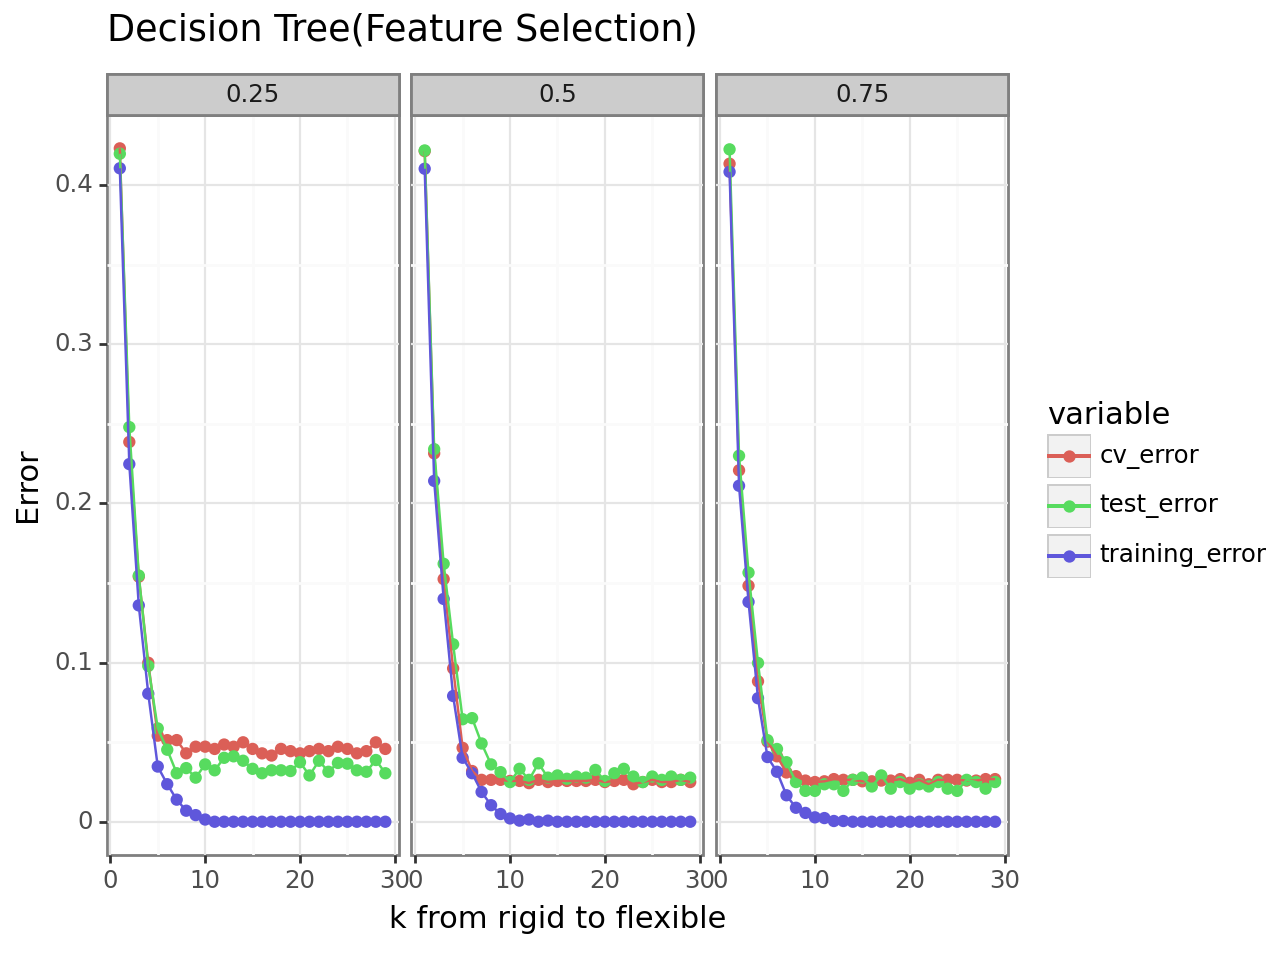

<Figure Size: (640 x 480)>

In [119]:
df_results_dfdtree_FS = pd.melt(results_dfdtree_FS, id_vars=["k", 'trainning size'], value_vars=["cv_error", 'training_error', 'test_error'])
p4 = (ggplot(df_results_dfdtree_FS, aes(x = 'k', y = 'value', color = 'variable'))
      + geom_point()
      + geom_line()
      + facet_wrap('trainning size', nrow = 1)
      + labs(x = 'k from rigid to flexible', y = 'Error', title = 'Decision Tree(Feature Selection)')
      + theme_minimal()
      + theme_bw()
      )
p4